In [1]:
import csv
from collections import defaultdict
from constants import *
import pandas as pd
import math 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy


In [2]:
valid_users = set()
user_train_count = defaultdict(int)     # number of training grids completed for each user
user_test_count = defaultdict(int)      # number of test grids completed for each user
user_test_score = defaultdict(int)     # cumulative training score for each user
user_test_timeouts = defaultdict(set)   # number of timeouts on test grids for each user
user_condition = defaultdict(int)       # whether user was assigned to complete training or not

with open('data/training_experiment_raw.csv', encoding='utf-8-sig') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        user = row['userid']
        valid_users.add(user)
        if row['step'] == '6':          # step 6 contains metadata for the whole trial such as total reward
            user_condition[user] = row['training'] == '1'
            if row['type'] == "train":
                user_train_count[user] += 1
            elif row['type'] == "test":
                user_test_count[user] += 1
                user_test_score[user] += int(row['reward_cum'])
            if row['timeout'] == '1':
                user_test_timeouts[user].add(int(row['gridnum']))

# exclude users who did not complete all training and test grids, scored less than -35 points in test, or timed out 6 or more times
def include_user(user):
    include_user = True
    user_timeouts = user_test_timeouts[user]
    if user_test_score[user]<-35 or user_test_count[user]!=24:
        include_user = False
    if len([x for x in user_timeouts if 100<x<200])>=2 or len([x for x in user_timeouts if 200<x<300])>=2:
        include_user = False
    if user_condition[user] == True and (user_train_count[user]!=60):
        include_user = False
    return include_user


print("Number of users before exclusions: " + str(len(valid_users)))       
valid_users = set(filter(include_user, valid_users))
print("Number of users after exclusions: " + str(len(valid_users)))

Number of users before exclusions: 645
Number of users after exclusions: 398


In [3]:
best_score_count = defaultdict(int)     # The number of grids where the user achieved the best score for each grid type and manipulation
total_count = defaultdict(int)          # The total number of grids completed for each grid type and manipulation
data = []

with open('data/training_experiment_raw.csv', encoding='utf-8-sig') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        gridnum = int(row['gridnum'])
        userid = row['userid']
        # looks only at final results for test grids of interest where user did not time out
        if  (gridnum in MUST_PUSH_GRIDNUMS or gridnum in MUST_SWITCH_GRIDNUMS) and userid in valid_users and not gridnum in user_test_timeouts[userid] and row['step']=='6' and gridnum not in [204,208]:
            score_dif = int(row['reward_cum'])-int(row['reward_max'])
            training = user_condition[userid]
            push_val = 0.5
            if training == True:
                train = 0.5 
            else:
                train = -0.5 
            if gridnum in MUST_PUSH_GRIDNUMS: 
                push_val = 0.5
            elif gridnum in MUST_SWITCH_GRIDNUMS:
                push_val = -0.5
           
            bin_num = (gridnum//100-1)*2 + int(training)  # assign a bin for each unique gridtype and time constraint combination
            if score_dif == 0:
                best_score_count[bin_num] += 1
            total_count[bin_num] += 1
            data.append([score_dif, userid, gridnum, push_val, train*push_val, train])

df = pd.DataFrame(data,columns=['score_dif', 'user_id', 'grid_num', 'push', 'train_x_push', 'train'])
df.to_csv('data/training_data_coded.csv')

In [4]:
df.loc[(df['user_id']=='390') & (df['grid_num'] > 100) & (df['grid_num']<200)]

,score_dif,user_id,grid_num,push,train_x_push,train
1245,-1,390,102,0.5,0.25,0.5
1276,-1,390,104,0.5,0.25,0.5


(398, 2) (130, 2)


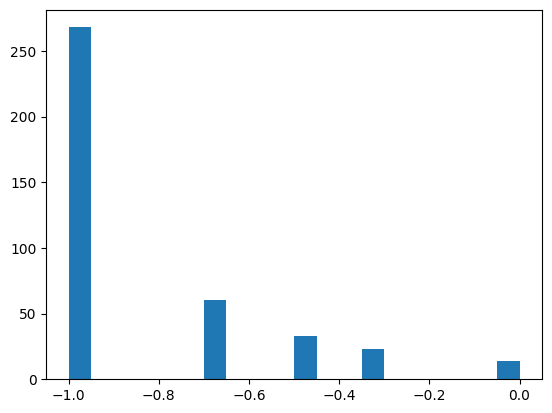

In [5]:
x = df.loc[(df['grid_num'] > 100) & (df['grid_num']<200)].groupby('user_id',as_index=False)['score_dif'].mean()
plt.hist(x['score_dif'], bins=20)
print(x.shape, x.loc[x['score_dif']!=-1].shape)
x.to_csv('exp2_push_performance_per_user.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


defaultdict(<class 'int'>, {2: 173, 0: 67, 1: 106, 3: 321})


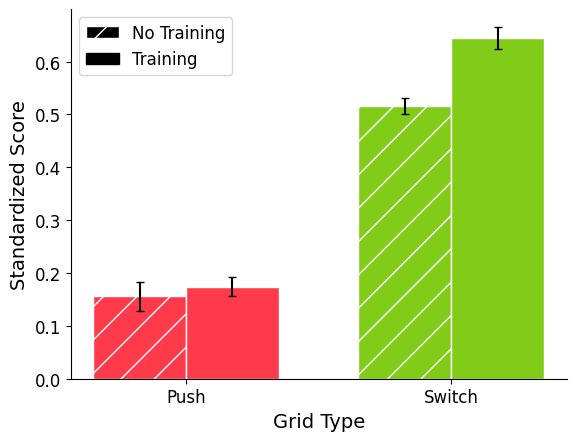

In [17]:
# Compute proportion of grids on which the best score was achieved 
print(best_score_count)
proportion = {}
for bin_num, count in best_score_count.items():
    proportion[bin_num] = count/total_count[bin_num]

# Compute standard error of mean
sem = []
for bin_num, count in best_score_count.items():
    x = np.concatenate((np.zeros(total_count[bin_num]-count),np.ones(count)))
    sem.append(scipy.stats.sem(x))

# Define labels, positions, bar heights and error bar heights
labels = ['Push', 'Switch']
notrain_proportions = []
notrain_error = []
train_proportions = []
train_error = []

for i in range(4):
    if i%2==0:
        notrain_proportions.append(proportion[i])
        notrain_error.append(sem[i])
    else:
        train_proportions.append(proportion[i])
        train_error.append(sem[i])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
color=['#FF3B4B', '#81CC18']
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, notrain_proportions, width, yerr=notrain_error, capsize=3, color=color,  hatch="/", edgecolor='white')
rects2 = ax.bar(x + width/2, train_proportions, width, yerr=train_error, capsize=3, color=color,  edgecolor='white')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Standardized Score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_xlabel('Grid Type')
ax.legend()
train = mpatches.Patch(color='black',  label='Training')
no_train = mpatches.Patch(edgecolor='white', facecolor='black', hatch="/", label='No Training')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.legend(handles=[no_train,train], fontsize=12)
plt.show()

In [21]:
for idx, p in enumerate(notrain_proportions):
    print("No Training " + labels[idx] + ": " + '{:.1%}'.format(p))
for idx, p in enumerate(train_proportions):
    print("Training " + labels[idx] + ": " + '{:.1%}'.format(p))

No Training Push: 15.7%
No Training Switch: 48.9%
Training Push: 17.8%
Training Switch: 64.3%
